In [4]:
import numpy as np
from multiprocessing import Pool

from functools import partial
import pickle as pkl
import gzip
import os

import games

import TSPM
import PM_DMED
import bpm
import cbp

import subprocess

def evaluate_parallel(nbCores, n_folds, horizon, alg, game, type, label):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    task = Evaluation(horizon, )

    np.random.seed(1)
    distributions = []
    tasks = []
    nfold_list =[]
    labels = []

    for jobid in range(n_folds):
        
        if type == 'imbalanced' :
            p = np.random.uniform(0, 0.2) 
        else:
            p = np.random.uniform(0.4,0.5)
        distributions.append( [p, 1-p] )
        tasks.append( type )
        nfold_list.append(n_folds)
        labels.append( label )

    return np.asarray(  pool.map( partial( task.eval_policy_once, alg, game ), zip(distributions ,tasks, nfold_list, labels, range(n_folds)) ) ) 



class Evaluation:

    def __init__(self, horizon, ):
        self.horizon = horizon

    def get_outcomes(self, game):
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):

        alg.reset()

        distribution, task, nfold, label, jobid = job

        np.random.seed(jobid)

        outcome_distribution =  {'spam':distribution[0],'ham':distribution[1]}

        game.set_outcome_distribution( outcome_distribution, jobid )
        outcomes = self.get_outcomes(game)

        action_counter = np.zeros( (game.n_actions, self.horizon) )        

        for t in range(self.horizon):

            # policy chooses one action
            action = alg.get_action(t, None)

            # Environment chooses one outcome
            outcome = outcomes[t]

            # print('t', t, 'action', action, 'outcome', outcome, )
            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, None, t)

            for i in range(game.n_actions):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] +1
                else:
                    action_counter[i][t] = action_counter[i][t-1]

        regret = np.array( [ game.delta(i) for i in range(game.n_actions) ] ).T @ action_counter

        with gzip.open( './results/{}/{}_{}_{}_{}_{}.pkl.gz'.format(game.name, task,  self.horizon, nfold, label, jobid) ,'wb') as f:
                pkl.dump(regret,f)

        print('finished {}'.format(jobid))

        return regret


In [4]:
import randcbp
horizon = 20000
game = games.apple_tasting(False)
# alg = TSPM.TSPM_alg(game, horizon, 1) #, TSPM.TSPM_alg(game, horizon, 0),
alg = cbp.CBP(  game, 1.01) 
# alg = randcbp.RandCBP(  game, 1.01, 1, 10, 10e-7) 
label = 'CBP' #, 'TSPM_0'   
task = Evaluation(horizon, )
p = 0.1
job = [p, 1-p],'imbalanced',96,'CBP', 4
result = task.eval_policy_once(alg, game, job)

t 0 action 0 outcome 1
t 1 action 1 outcome 1
pair [0, 1] tdelta [-1.] confidence 0.8367070289925529
pair [1, 0] tdelta [1.] confidence 0.8367070289925529
t 2 action 0 outcome 1
pair [0, 1] tdelta [-1.] confidence 1.0533747726022258
pair [1, 0] tdelta [1.] confidence 1.0533747726022258
t 3 action 1 outcome 1
pair [0, 1] tdelta [-1.] confidence 0.8367070289925529
pair [1, 0] tdelta [1.] confidence 0.8367070289925529
t 4 action 0 outcome 1
pair [0, 1] tdelta [-1.] confidence 0.9015354378942741
pair [1, 0] tdelta [1.] confidence 0.9015354378942741
t 5 action 0 outcome 1
pair [0, 1] tdelta [-1.] confidence 0.9512300100186956
pair [1, 0] tdelta [1.] confidence 0.9512300100186956
t 6 action 0 outcome 1
pair [0, 1] tdelta [-1.] confidence 0.9913045068357821
pair [1, 0] tdelta [1.] confidence 0.9913045068357821
t 7 action 0 outcome 0
pair [0, 1] tdelta [-1.] confidence 1.0247526426159228
pair [1, 0] tdelta [1.] confidence 1.0247526426159228
t 8 action 1 outcome 1
pair [0, 1] tdelta [-1.] confi

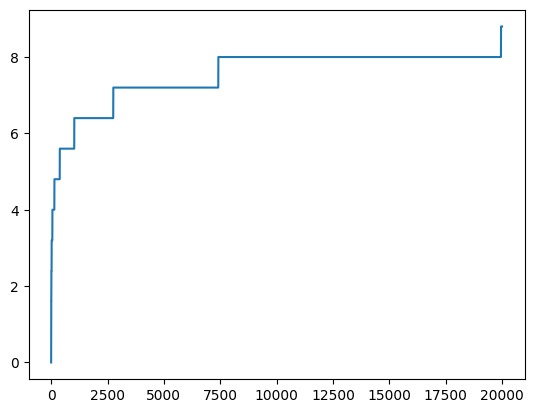

In [5]:
import matplotlib.pyplot as plt
plt.plot(range(len(result)),result)

In [7]:


n_cores = 8
n_folds = 96
horizon = 20000

# game = games.apple_tasting(False)
game = games.label_efficient()
# algos = [ PM_DMED.PM_DMED(  game, horizon, 0) ,bpm.BPM(game,horizon) ]
# labels = [  'PM_DMED', 'BPMLeast'  ]  

# game = games.label_efficient()
# algos = [ PM_DMED.PM_DMED(  game, horizon, 0) ,bpm.BPM(game,horizon) ]
# labels = [  'PM_DMED',  ]  #  'BPMLeast' 

algos = [ cbp.CBP(  game, 1.01)  ] #,TSPM.TSPM_alg(game, horizon, 1), TSPM.TSPM_alg(game, horizon, 0),
labels = [  'CBP', ] # 'TSPM_1', 'TSPM_0'   

for task in ['balanced', 'imbalanced']:
    for alg, label in zip( algos,  labels):

        result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, task, label)

        with gzip.open( './results/{}/{}_{}_{}_{}.pkl.gz'.format(game.name, task , horizon, n_folds,  label) ,'wb') as g:

            for jobid in range(n_folds):

                with gzip.open(  './results/{}/{}_{}_{}_{}_{}.pkl.gz'.format(game.name, task, horizon, n_folds,  label, jobid) ,'rb') as f:
                    r = pkl.load(f)

                pkl.dump( r, g)
                        
                bashCommand = 'rm ./results/{}/{}_{}_{}_{}_{}.pkl.gz'.format(game.name, task, horizon, n_folds,  label, jobid)
                process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
                output, error = process.communicate()




nbCores: 8 nbFolds: 96 Horizon: 20000
finished 21
finished 15finished 6

finished 12
finished 0
finished 9
finished 18
finished 3
finished 13
finished 16
finished 7
finished 22
finished 1finished 19

finished 10
finished 4
finished 8
finished 14
finished 20
finished 17
finished 23
finished 11
finished 2
finished 5
finished 24
finished 30
finished 33
finished 27
finished 45
finished 42
finished 39
finished 36
finished 25
finished 31
finished 34
finished 46
finished 28
finished 40
finished 43
finished 37
finished 26
finished 41
finished 47
finished 29
finished 35
finished 32
finished 44
finished 38
finished 51
finished 54
finished 48
finished 60
finished 63
finished 57
finished 66
finished 69
finished 55
finished 52
finished 49
finished 61
finished 64
finished 70
finished 58
finished 67
finished 50
finished 53
finished 62
finished 56
finished 65
finished 68
finished 71
finished 59
finished 72
finished 75
finished 84
finished 78
finished 81
finished 87
finished 90
finished 93
finished 76f

In [6]:
def loadall_results(path, horizon, n_folds):
    result = np.zeros( (n_folds, horizon) )
    with gzip.open(  path ,'rb') as f:
        for i in range(n_folds):
            try:
                res = pkl.load(f)
                result[i] = res
            except EOFError:
                break
    return result

game = 'LE'
task = 'balanced'
direct = './results/{}/'.format(game)
path = os.path.join(direct, '{}_20000_96_{}.pkl.gz'.format(task, label) )
result = loadall_results(path, horizon, n_folds)
result

array([[  0.5582978 ,   0.5582978 ,   0.6748934 , ...,  50.92169536,
         50.92169536,  50.92169536],
       [  0.52796755,   0.52796755,   0.58390265, ...,  16.51024774,
         16.51024774,  16.51024774],
       [  0.59998856,   0.59998856,   0.79996569, ..., 175.99662594,
        175.99662594, 175.99662594],
       ...,
       [  0.54216104,   0.54216104,   0.62648312, ..., 287.42967251,
        287.42967251, 287.42967251],
       [  0.55918632,   0.55918632,   0.67755896, ..., 117.54749978,
        117.54749978, 117.54749978],
       [  0.5762973 ,   0.5762973 ,   0.72889191, ...,  99.27573054,
         99.27573054,  99.27573054]])

In [17]:
result[0]

array([0.5582978, 0.5582978, 0.6748934, ..., 0.6748934, 0.6748934,
       0.6748934])